#Import thư viện

In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D
from keras.layers import Dropout, Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt

#Đọc dữ liệu

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/DS202_Project/18520767/DATA/FINAL_DATA/train.csv')

df_test = pd.read_csv('/content/drive/MyDrive/DS202_Project/18520767/DATA/FINAL_DATA/test.csv')

df_valid = pd.read_csv('/content/drive/MyDrive/DS202_Project/18520767/DATA/FINAL_DATA/val.csv')
X_train = df_train["COMMENT"]
X_val = df_valid["COMMENT"]
X_test = df_test["COMMENT"]
y_train = df_train["LABEL"]
y_val = df_valid["LABEL"]
y_test = df_test["LABEL"]
X_train= X_train.values.astype('U')
X_val= X_val.values.astype('U')
X_test= X_test.values.astype('U')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tải model Pretrained model

In [7]:
#import requests
#url='https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz'
#r = requests.get(url, allow_redirects=True)

#open('cc.vi.300.vec.gz','wb').write(r.content)

# extract file gzip chứa model

In [8]:
#import gzip

#def gunzip(source_filepath, dest_filepath, block_size=65536):
#    with gzip.open(source_filepath, 'rb') as s_file, \
#            open(dest_filepath, 'wb') as d_file:
#        while True:
#            block = s_file.read(block_size)
#            if not block:
#                break
#            else:
#                d_file.write(block)
#gunzip('/content/cc.vi.300.vec.gz','/content/drive/My Drive/DS202_Project/Train_model/cc.vi.300.vec')

In [9]:
EMBEDDING_FILE = '/content/drive/My Drive/DS202_Project/Train_model/cc.vi.300.vec'

In [10]:
y_train=pd.get_dummies(data=y_train)
y_val=pd.get_dummies(data=y_val)
y_test=pd.get_dummies(data=y_test)

In [11]:
y_train.head(5)

,negative,neutral,positive
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,1,0,0


# Tiền xử lý dữ liệu

In [12]:
max_features=4840
maxlen=100
embed_size=300

#Trích xuất đặc trưng

In [13]:
tokenizer = text.Tokenizer(num_words=max_features, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')  
tokenizer.fit_on_texts(list(X_train))

In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

In [15]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
X_val = sequence.pad_sequences(X_val, maxlen=maxlen)

In [16]:
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs  
 
word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))

In [17]:
for word, i in word_index.items():
    if i >= max_features:
        continue
  
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Tạo và training model với Bi-LSTM

In [19]:
inp = Input(shape=(maxlen,))
 
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = SpatialDropout1D(0.35)(x)
 
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)
 
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
 
out = Dense(3, activation='relu')(x)

model = Model(inp, out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     1452000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 128)     186880      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [21]:
history=model.fit(X_train, y_train, batch_size = 32, validation_data = (X_val, y_val), epochs = 15)

Epoch 1/15
188/188 [==============================] - 153s 752ms/step - loss: 0.7234 - acc: 0.4374 - f1_m: 0.1950 - precision_m: 0.3874 - recall_m: 0.1550 - val_loss: 0.5867 - val_acc: 0.5172 - val_f1_m: 0.3982 - val_precision_m: 0.6271 - val_recall_m: 0.2945
Epoch 2/15
188/188 [==============================] - 142s 755ms/step - loss: 0.6076 - acc: 0.5576 - f1_m: 0.4488 - precision_m: 0.6714 - recall_m: 0.3556 - val_loss: 0.5399 - val_acc: 0.6000 - val_f1_m: 0.5598 - val_precision_m: 0.6482 - val_recall_m: 0.4959
Epoch 3/15
188/188 [==============================] - 141s 750ms/step - loss: 0.4890 - acc: 0.6921 - f1_m: 0.6478 - precision_m: 0.7438 - recall_m: 0.5811 - val_loss: 0.5975 - val_acc: 0.5646 - val_f1_m: 0.5348 - val_precision_m: 0.5843 - val_recall_m: 0.4947
Epoch 4/15
188/188 [==============================] - 141s 750ms/step - loss: 0.4450 - acc: 0.7335 - f1_m: 0.6945 - precision_m: 0.7739 - recall_m: 0.6406 - val_loss: 0.8037 - val_acc: 0.6095 - val_f1_m: 0.5707 - val_pre

In [22]:
predictions = model.predict(X_test, batch_size= 128, verbose=1)

16/16 [==============================] - 1s 59ms/step


# Đánh giá Model

In [23]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test metrics:', score)

32/32 [==============================] - 2s 53ms/step - loss: 1.9208 - acc: 0.5641 - f1_m: 0.5534 - precision_m: 0.5769 - recall_m: 0.5325
Test metrics: [1.9208040237426758, 0.5640897750854492, 0.5534341335296631, 0.5768937468528748, 0.5324823260307312]


In [24]:
result = y_test.copy()
result[['negative','neutral','positive']] = predictions
result['LABEL']=0
my_tags = ['negative','neutral','positive']
from sklearn.metrics import classification_report
y_pred = np.argmax(np.array(result[['negative','neutral','positive']]), axis=1)
y_pred_bool= pd.DataFrame({'LABEL':y_pred})
model_json = model.to_json()
with open("/content/drive/MyDrive/BaoCaoThucHanh/Model save LSTM UIT-SNC/model_num_bc_15.json", "w") as json_file:
    json_file.write(model_json)
y_pred_bool.to_csv('/content/drive/MyDrive/BaoCaoThucHanh/Model save LSTM UIT-SNC/result_15.csv')
model.save_weights("/content/drive/MyDrive/BaoCaoThucHanh/Model save LSTM UIT-SNC/model_15.h5")

In [25]:
print(classification_report(y_test, pd.get_dummies(data=y_pred_bool, columns=['LABEL']),target_names=my_tags, digits=4))

              precision    recall  f1-score   support

    negative     0.5532    0.6231    0.5861       467
     neutral     0.5914    0.6637    0.6255       892
    positive     0.5188    0.3839    0.4413       646

   micro avg     0.5641    0.5641    0.5641      2005
   macro avg     0.5545    0.5569    0.5509      2005
weighted avg     0.5591    0.5641    0.5570      2005
 samples avg     0.5641    0.5641    0.5641      2005



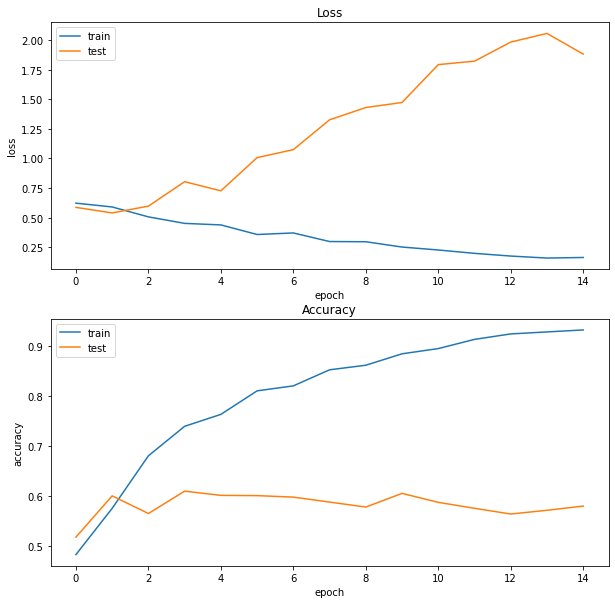

In [26]:
# plot loss during training
plt.figure(figsize=[10,10])
plt.subplot(211)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

#Confusion Matrix

In [27]:
#df_test = pd.read_csv('/content/drive/MyDrive/DS202_Project/NIU_PHAI_NỒ/test.csv')
#y_test = df_test["LABEL"]

In [28]:
#y_test.replace('negative',0, inplace=True)
#y_test.replace('neutral',1, inplace=True)
#y_test.replace('positive',2, inplace=True)

In [29]:
#y_pred = y_pred_bool
#from sklearn.metrics import accuracy_score,  precision_score, recall_score, confusion_matrix
#import seaborn as sn
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
#sn.heatmap(cm, fmt="g" ,cmap="Blues", annot=True,annot_kws={"size": 16}, )
#print(accuracy_score(y_test, y_pred))